In [28]:
import networkx as nx
import igraph as ig
import pickle
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def load_part(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
questions = pd.read_csv("../data/cache/prepared_questions_metrics.csv")
answers = pd.read_csv(
    "../data/cache/prepared_answers_metrics.csv", low_memory=False)

In [4]:
tags_graph = ig.Graph.from_networkx(
    nx.read_edgelist("../data/cache/tagsG.edgelist"))
answers_graph = ig.Graph.from_networkx(
    nx.read_edgelist("../data/cache/answersG.edgelist"))

In [5]:
tags_part = load_part("../data/cache/user_communities_a.pickle")
answers_part = load_part("../data/cache/user_communities_t.pickle")

In [6]:
def compute(G, partition, questions, answers):
    community_stats = {}

    complex_ids = questions[questions["is_complex"]]["Id"].to_list()

    for i, community in enumerate(partition):
        members = G.vs[community]
        total_answers = 0
        total_complex_answers = 0

        unique_answerers = set()
        unique_complex_answerers = set()

        for user in members:
            user_id = user["_nx_name"][1:]
            user_answers = answers[answers["OwnerUserId"] == float(user_id)]

            total_answers += len(user_answers)
            unique_answerers.add(user_id)

            complex_user_answers = answers[(answers["OwnerUserId"] == float(
                user_id)) & (answers["ParentId"].isin(complex_ids))]
            total_complex_answers += len(complex_user_answers)
            if len(complex_user_answers) > 0:
                unique_complex_answerers.add(user_id)

        community_stats[i] = {
            "community": community,
            "total_answers": total_answers,
            "total_complex_answers": total_complex_answers,
            "unique_answerers": len(unique_answerers),
            "unique_complex_answerers": len(unique_complex_answerers),
            "complex_to_total_ratio": total_complex_answers / total_answers if total_answers > 0 else 0,
            "complex_to_total_answerers_ratio": len(unique_complex_answerers) / len(unique_answerers) if len(unique_answerers) > 0 else 0
        }

    return community_stats

In [7]:
result = compute(tags_graph, tags_part, questions, answers)

In [14]:
def get_communities(res, key_col):
    sorted_data = sorted(
        res.items(), key=lambda item: item[1][key_col], reverse=True)

    sorted_dict = {k: v for k, v in sorted_data}

    i = 0
    for key, value in sorted_dict.items():
        print(f"{key}: {value}")
        i += 1
        if i == 10:
            break

In [15]:
barrier = 10
filtered_result = {k: v for k,
                   v in result.items() if v["total_answers"] >= barrier}

In [19]:
# отношение ответов на сложные вопросы ко всем ответам
get_communities(filtered_result, "complex_to_total_ratio")

1562: {'community': [3952, 3953, 3954], 'total_answers': 15, 'total_complex_answers': 12, 'unique_answerers': 3, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.8, 'complex_to_total_answerers_ratio': 0.3333333333333333}
1071: {'community': [2806, 2807, 2808], 'total_answers': 19, 'total_complex_answers': 10, 'unique_answerers': 3, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.5263157894736842, 'complex_to_total_answerers_ratio': 0.6666666666666666}
599: {'community': [1653, 1654], 'total_answers': 14, 'total_complex_answers': 7, 'unique_answerers': 2, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.5, 'complex_to_total_answerers_ratio': 0.5}
2267: {'community': [5533, 5534], 'total_answers': 34, 'total_complex_answers': 17, 'unique_answerers': 2, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.5, 'complex_to_total_answerers_ratio': 0.5}
1347: {'community': [3449, 3450], 'total_answers': 24, 'total_complex_answers': 11, 'unique_answerers': 2

In [20]:
# отношение ответчиков на сложные вопросы ко всем ответчикам
get_communities(filtered_result, "complex_to_total_answerers_ratio")

957: {'community': [2536, 2537], 'total_answers': 88, 'total_complex_answers': 18, 'unique_answerers': 2, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.20454545454545456, 'complex_to_total_answerers_ratio': 1.0}
279: {'community': [861, 862, 863], 'total_answers': 75, 'total_complex_answers': 21, 'unique_answerers': 3, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.28, 'complex_to_total_answerers_ratio': 0.6666666666666666}
307: {'community': [937, 938, 939], 'total_answers': 28, 'total_complex_answers': 9, 'unique_answerers': 3, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.32142857142857145, 'complex_to_total_answerers_ratio': 0.6666666666666666}
1071: {'community': [2806, 2807, 2808], 'total_answers': 19, 'total_complex_answers': 10, 'unique_answerers': 3, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.5263157894736842, 'complex_to_total_answerers_ratio': 0.6666666666666666}
1807: {'community': [4522, 4523, 4524], 'total_answers': 32

Есть очень много отвечающие пользователи, у которых часть ответов на сложные вопросы

In [24]:
filtered_result = {k: v for k,
                   v in result.items() if v["unique_answerers"] >= 5 and v["total_answers"] >= 10}

In [25]:
get_communities(filtered_result, "complex_to_total_ratio")

1046: {'community': [2743, 2744, 2745, 2746, 2747, 2748], 'total_answers': 25, 'total_complex_answers': 6, 'unique_answerers': 6, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.24, 'complex_to_total_answerers_ratio': 0.16666666666666666}
429: {'community': [1244, 1245, 1246, 1247, 1248, 1249], 'total_answers': 10, 'total_complex_answers': 2, 'unique_answerers': 6, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.2, 'complex_to_total_answerers_ratio': 0.16666666666666666}
241: {'community': [767, 768, 769, 770, 771, 772], 'total_answers': 11, 'total_complex_answers': 2, 'unique_answerers': 6, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.18181818181818182, 'complex_to_total_answerers_ratio': 0.16666666666666666}
299: {'community': [912, 913, 914, 915, 916, 917], 'total_answers': 51, 'total_complex_answers': 7, 'unique_answerers': 6, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.13725490196078433, 'complex_to_total_answerers_ratio': 0.33333

In [26]:

get_communities(filtered_result, "complex_to_total_answerers_ratio")

190: {'community': [634, 635, 636, 637, 638], 'total_answers': 399, 'total_complex_answers': 38, 'unique_answerers': 5, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.09523809523809523, 'complex_to_total_answerers_ratio': 0.4}
299: {'community': [912, 913, 914, 915, 916, 917], 'total_answers': 51, 'total_complex_answers': 7, 'unique_answerers': 6, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.13725490196078433, 'complex_to_total_answerers_ratio': 0.3333333333333333}
70: {'community': [266, 267, 268, 269, 270, 271, 272, 273, 274, 275], 'total_answers': 17, 'total_complex_answers': 2, 'unique_answerers': 10, 'unique_complex_answerers': 2, 'complex_to_total_ratio': 0.11764705882352941, 'complex_to_total_answerers_ratio': 0.2}
136: {'community': [472, 473, 474, 475, 476], 'total_answers': 84, 'total_complex_answers': 4, 'unique_answerers': 5, 'unique_complex_answerers': 1, 'complex_to_total_ratio': 0.047619047619047616, 'complex_to_total_answerers_ratio': 0.2}
1: {

In [27]:
complex_answers = [v["complex_to_total_ratio"] for v in result.values()]
complex_answerers = [v["complex_to_total_answerers_ratio"]
                     for v in result.values()]

In [49]:
def plot(values):
    plt.hist(values, bins=100, alpha=0.6)

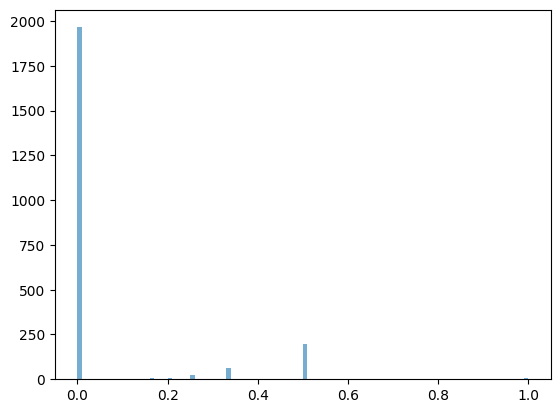

In [50]:
plot(complex_answerers)

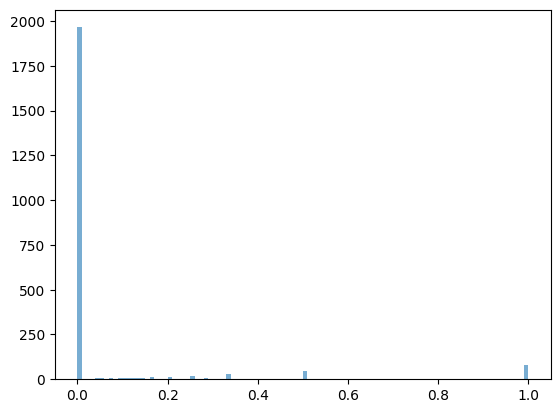

In [51]:
plot(complex_answers)